In [1]:
training_set_size = 5
num_particles = 50
BATCH_SIZE = 512
IMAGE_SIZE = 64
NUMBER_OF_PARTICLES = 0.0 #number of extra particles in image will be round(poi(NUMBER_OF_PARTICLES))
Z_RANGE = 20
NEW_MODELS=1
save_model_path = "/content/drive/My Drive/imag_n_real_feb22/"
models_path = "/content/drive/My Drive/imag_n_real_feb21/"

In [2]:
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==1.0.1
    !pip install mat73

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow.keras as keras
import mat73
from matplotlib import colors
from cycler import cycler
from google.colab import drive

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

def save_models(models):
    drive.mount('/content/drive')
    for i, model in enumerate(models):
        model.save(save_model_path+f"model{i}")

def load_models(path, NUMBER_OF_MODELS):
    """Load models and return them in a list"""
    drive.mount('/content/drive')
    return [models.load_model(path+f"/model{i}") for i in range(NUMBER_OF_MODELS)]

     |████████████████████████████████| 137 kB 31.2 MB/s 
     |████████████████████████████████| 209 kB 64.2 MB/s 
     |████████████████████████████████| 1.1 MB 55.8 MB/s 
     |████████████████████████████████| 12.5 MB 47.9 MB/s 
     |████████████████████████████████| 109 kB 69.5 MB/s 
     |████████████████████████████████| 51 kB 596 kB/s 
     |████████████████████████████████| 251 kB 52.1 MB/s 
     |████████████████████████████████| 546 kB 53.8 MB/s 
     |████████████████████████████████| 462 kB 56.2 MB/s 
  Created wheel for pydeepimagej: filename=pydeepimagej-2.3.3-py3-none-any.whl size=24230 sha256=f2ec98203e27165131ea320bdfd4848a82bafb6394c68a8b4f39779c49adf38b
  Stored in directory: /root/.cache/pip/wheels/4a/05/98/e4bba4aca59759f5e635d6de7d953a9c60a3db586dd2d96dee
Successfully built pydeepimagej
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3

In [3]:
"""Import the validation set"""
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg

drive.mount('/content/drive')
filePath = "/content/drive/My Drive/valset/valset_1.mat"

data = mat73.loadmat(filePath)
data = data['CompletedTraces']

shape = [64, 64]
realM = np.zeros((len(data), 64, 64, 1))
imagM = 1j * np.ones((len(data), 64, 64, 1))

Mounted at /content/drive


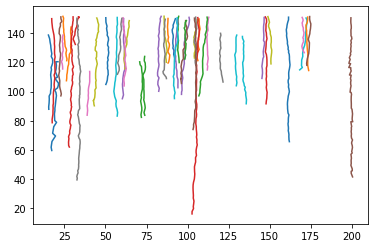

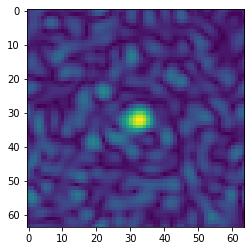

training images shape (5, 64, 64, 2)
validation images shape (59, 64, 64, 1)


In [4]:
"""Saves images and positions for individual particles."""
particles_timeseries = []
particles_positions = []

for i in range(num_particles):
    frames = data[i]["Positions"][:,0].astype(int)
    positions = data[i]["Positions"][:,1:4]
    particles_positions.append(positions)

    roi_data = np.array(data[i]['ROI'][0])
    timeseries = []
    for j in range(roi_data.shape[0]):
        particleROI = np.fft.ifft2(exp_expand(roi_data[j,:], shape))
        particleROI = np.fft.fftshift(particleROI)
        particleROI = np.expand_dims(particleROI, axis = -1)
        timeseries.append(particleROI)
    particles_timeseries.append(np.array(timeseries))

for particle_id in range(num_particles):
    plt.plot(particles_positions[particle_id][:,0], particles_positions[particle_id][:,1])
plt.show()

for _ in range(1):
    plt.imshow(np.abs(particles_timeseries[0][_,:,:,0]))
    plt.show()

particle_id = 10

training_images = np.stack((np.real(particles_timeseries[particle_id])[:training_set_size,:,:,0], np.imag(particles_timeseries[particle_id][:training_set_size,:,:,0])), axis=-1)
print(f"training images shape {training_images.shape}")

validation_set = particles_timeseries[particle_id][training_set_size:,:,:,:]
print(f"validation images shape {validation_set.shape}")

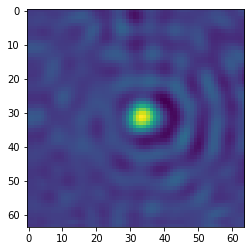

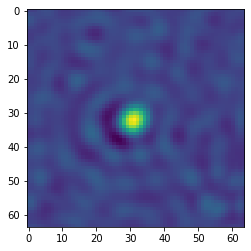

In [5]:
"""Create group/equivariance"""

crop_size = 64
padding = 32
wavelength = 525e-9
pixel_size = 114e-9 #??
crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size * 2, wavelength)
crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size * 2, wavelength)

args = dt.Arguments(
    translate=lambda: np.random.randn(2)*1,
    rotate=lambda: np.random.uniform(0, np.pi*2),
    z=lambda:np.random.uniform(low=-20, high=20),
)

group = ( 
    dt.Affine(rotate=args.rotate) 
    >> dt.Affine(translate=args.translate) 
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 0.00)
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
)

equivariance = (
    dt.models.lodestar.Rotational2DEquivariance(args.rotate)
    >> dt.models.lodestar.TranslationalEquivariance(args.translate)
    >> dt.models.lodestar.Equivariance(-1, args.z, indexes=2)
)

import random
training_set = dt.Value(lambda: random.choice(training_images)) 

for _ in range(2):
    x = (training_set>>group).update()()
    plt.imshow(x[..., 1])
    plt.show()


In [6]:
"""Create custom layers"""
from tensorflow.math import abs, angle, real, imag, subtract, multiply

class CustomLayerOne(keras.layers.Layer):
    "Dpes nothing"
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([real(norm_image), imag(norm_image), angle(image)], axis=-1)#tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)

class CustomLayerTwo(keras.layers.Layer):
    "Takes 2 layers as input and outputs 3 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([real(norm_image), imag(norm_image), abs(norm_image)], axis=-1)#tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)

class CustomLayerThree(keras.layers.Layer):
    "Takes 2 layers as input and outputs 4 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)


In [7]:
"""Create models"""
num_outputs = 3

def create_model(custom_layer):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,2)))
    model.add(custom_layer)
    model.add(keras.layers.Conv2D(32, 3, activation='relu'))
    model.add(keras.layers.Conv2D(32, 3, activation='relu', strides=(2,2)))
    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(num_outputs+1,1))
    model = dt.models.LodeSTAR(model=model, input_shape=(None, None, 2), num_outputs=num_outputs)
    model.specs = {"Custom layer": custom_layer}
    model.totalhistory = {"total_loss":[], "consistency_loss":[]}
    model.compile(loss=["mae", "mae", "mae"], optimizer=tf.keras.optimizers.Adam(), loss_weights=[0.8, 0.8, 1])
    return model

models = [create_model(CustomLayerThree())]

In [8]:
"""Create generator"""
generator = dt.models.lodestar.LodeSTARGenerator(
    training_set,
    num_outputs=num_outputs, 
    transformation_function=(group, equivariance), 
    batch_size=8, 
    min_data_size=200, 
    max_data_size=201,
)

Generating 200 / 200 samples before starting training


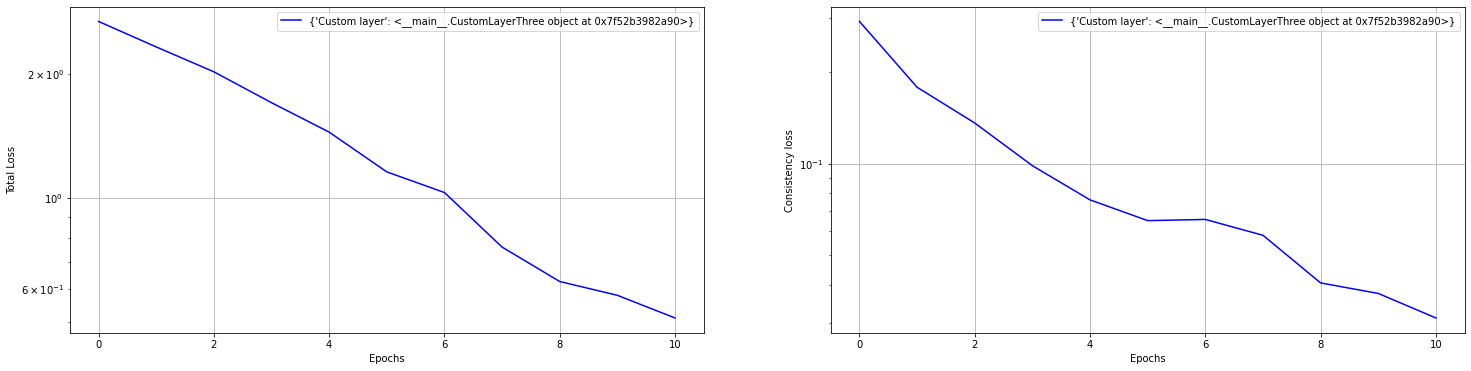

Generating 201 / 200 samples before starting training


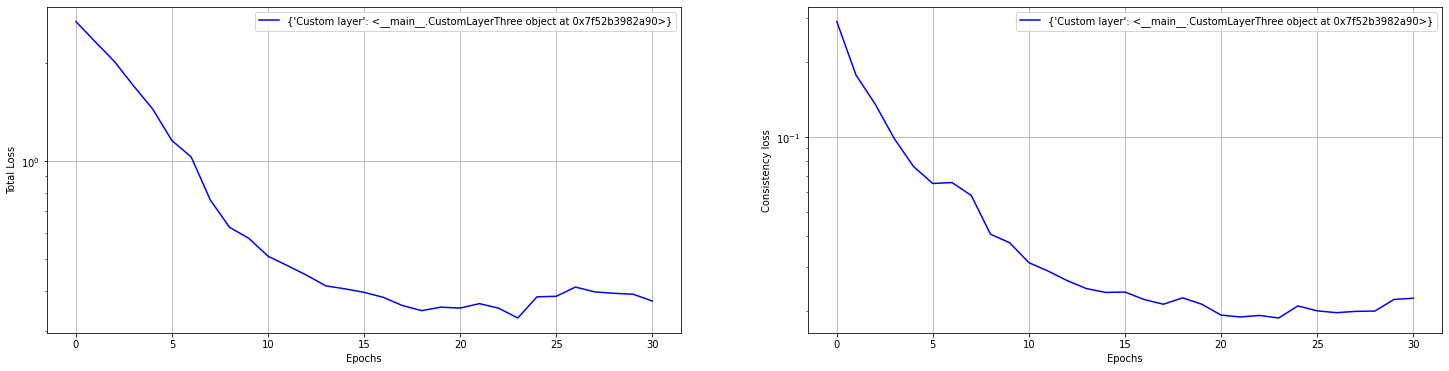

Generating 201 / 200 samples before starting training


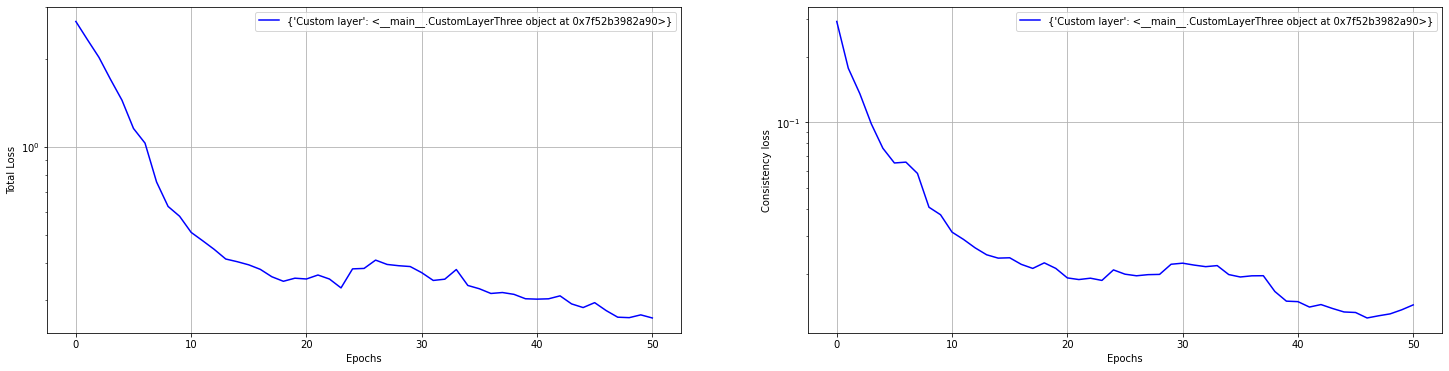

Generating 201 / 200 samples before starting training


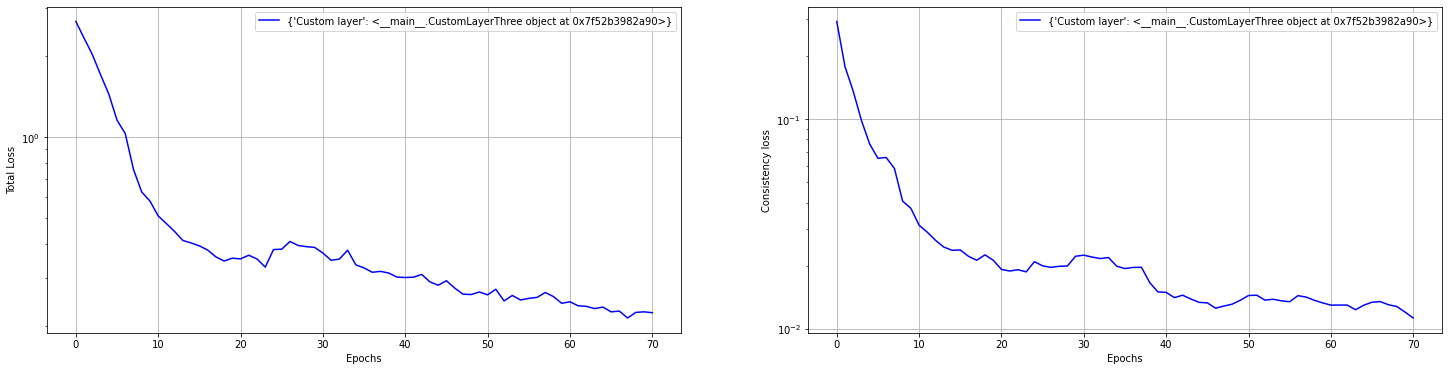

Generating 201 / 200 samples before starting training


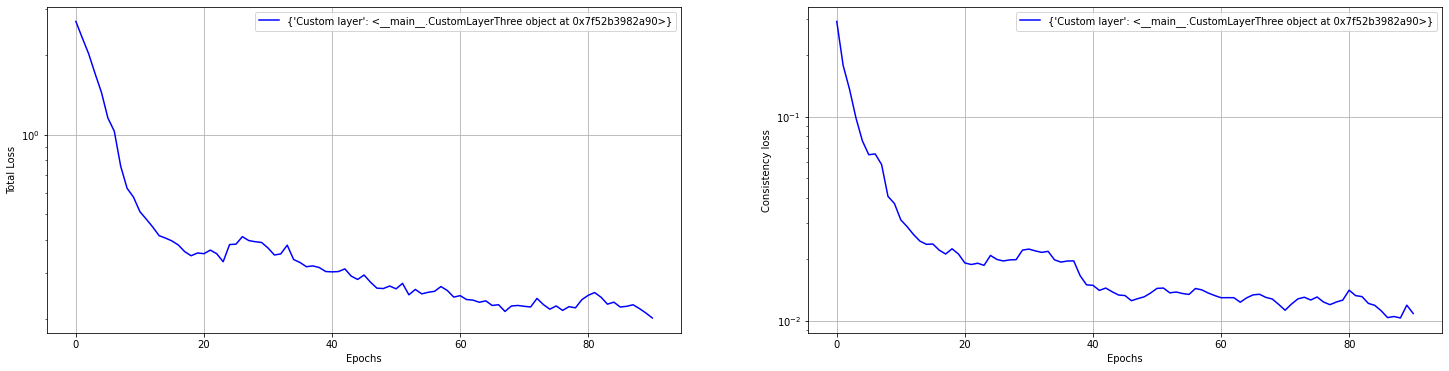

Generating 200 / 200 samples before starting training


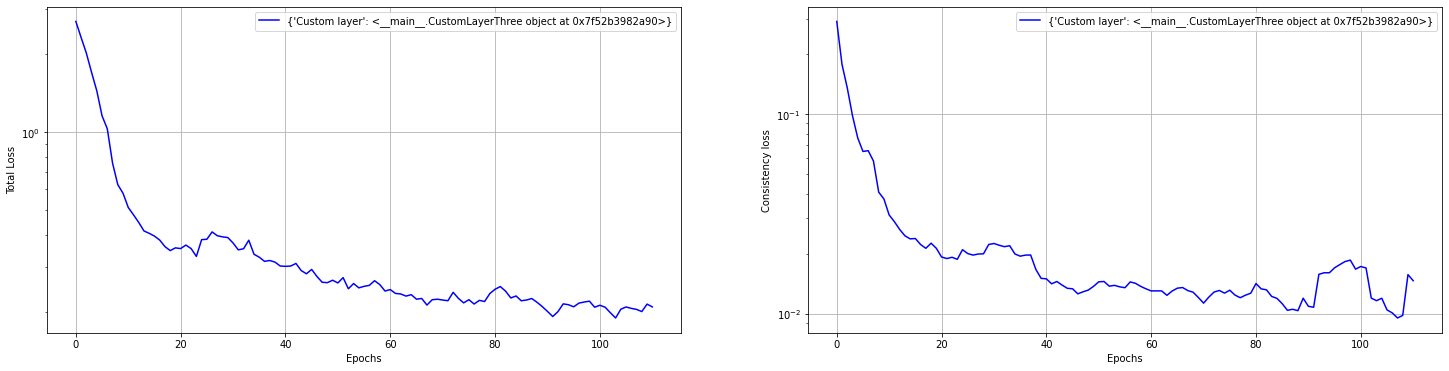

Generating 201 / 200 samples before starting training


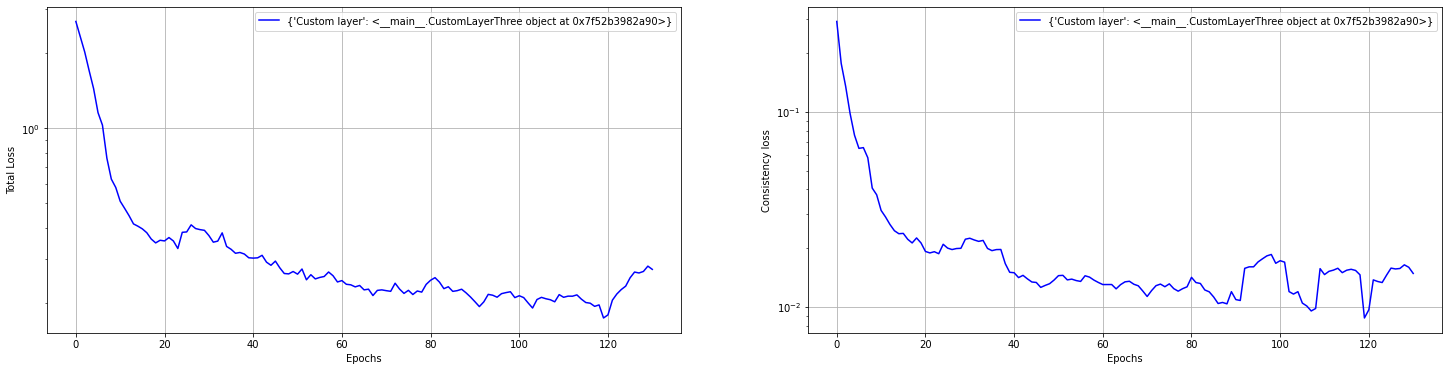

Generating 200 / 200 samples before starting training


KeyboardInterrupt: ignored

In [9]:
def save_progress(model, h):
    model.totalhistory["total_loss"].extend(h.history["total_loss"])
    model.totalhistory["consistency_loss"].extend(h.history["consistency_loss"])

def plot_progress(models):
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    cc = (cycler(color=list('bgrcmyk')))
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,6))
    ax1.set_prop_cycle(cc)
    ax2.set_prop_cycle(cc)

    for i, model in enumerate(models):
        ax1.plot(moving_average(model.totalhistory["total_loss"], 10), label=f"{model.specs}")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Total Loss")
        ax1.set_yscale("log")
        ax1.legend()

        ax2.plot(moving_average(model.totalhistory["consistency_loss"], 10), label=f"{model.specs}")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Consistency loss")
        ax2.set_yscale("log")
        ax2.legend()

    ax1.grid(True)
    ax2.grid(True)
    plt.show()

while True:
    with generator:
        for model in models:
            h = model.fit(generator, epochs=20, steps_per_epoch=100, verbose=0)
            save_progress(model, h)
        plot_progress(models)
        



In [10]:
#@title
def _propagate_field(field, Tz, z, x, y, K, C, k=2 * np.pi / 0.633):
    """
    Propagate field. Field =  a Complex array of row*col dimension
    """
    Field = np.fft.fft2(field)
    Field = C * Tz * Field
    Field = np.fft.ifft2(Field)

    return Field


def _precalc(field, px, k=2 * np.pi / 0.633):
    """
    Precalculate some constants for propagating field for faster computations.
    """
    yr, xr = field.real.shape

    x = 2 * np.pi / px * np.arange(-(xr / 2 - 1 / 2), (xr / 2 + 1 / 2), 1) / xr
    y = 2 * np.pi / px * np.arange(-(yr / 2 - 1 / 2), (yr / 2 + 1 / 2), 1) / yr
    KXk, KYk = np.meshgrid(x, y)

    K = np.real(
        np.sqrt(np.array(1 - (KXk / k) ** 2 - (KYk / k) ** 2, dtype=np.complex64))
    )
    # Create a circular disk here.
    C = np.fft.fftshift(((KXk / k) ** 2 + (KYk / k) ** 2 < 1) * 1.0)

    return x, y, K, C


def _precalc_Tz(k, zv, K, C):
    return [C * np.fft.fftshift(np.exp(k * 1j * z * (K - 1))) for z in zv]


def propagation_matrix(
    z,
    shape=(IMAGE_SIZE, IMAGE_SIZE),
    padding=64,
    wavelength=525e-9,
    pixel_size=1.13e-6,
):
    field = np.zeros(np.array(shape) + padding * 2)
    k = 2 * np.pi / wavelength * 1e-6
    x, y, K, C = _precalc(field, pixel_size * 1e6, k)
    return _precalc_Tz(k, z, K, C)

def pad_fft2(image, padding):
    im = np.copy(image)
    im = np.pad(im, (padding, padding), mode="symmetric")
    return np.fft.fft2(im)

def ft_transformation(image, Tz, Tzinv, i):
    if i < 0:
        propfac=1
        for j in range(int(np.abs(i))):
            propfac*=Tzinv
        image *= propfac
    else:
        propfac=1
        for j in range(int(np.abs(i))):
            propfac*=Tz
        image *= Tz ** i
    return image

def crop_center(img, cropx, cropy):
    """returns the center of img with size cropx,cropy"""
    y,x = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2    
    return img[starty:starty+cropy, startx:startx+cropx]

def propagate(image, z):
    """Re-propagate the images using PAS"""
    image_size = len(image[:,0,0])
    propagate_up, propagate_down = propagation_matrix(
        [.05, -.05],
        shape=(image_size, image_size),
        padding=32,
        wavelength=wavelength,
        pixel_size=pixel_size,
        )
    im = image[:,:,0]
    ft_image = pad_fft2(im, 32)
    prop_ft_image = ft_transformation(ft_image, propagate_down, propagate_up, z)
    return np.expand_dims(crop_center(np.fft.ifft2(prop_ft_image),IMAGE_SIZE, IMAGE_SIZE),axis=-1)

{'Custom layer': <__main__.CustomLayerThree object at 0x7f52b3982a90>}
PROPAGERADE BILDER


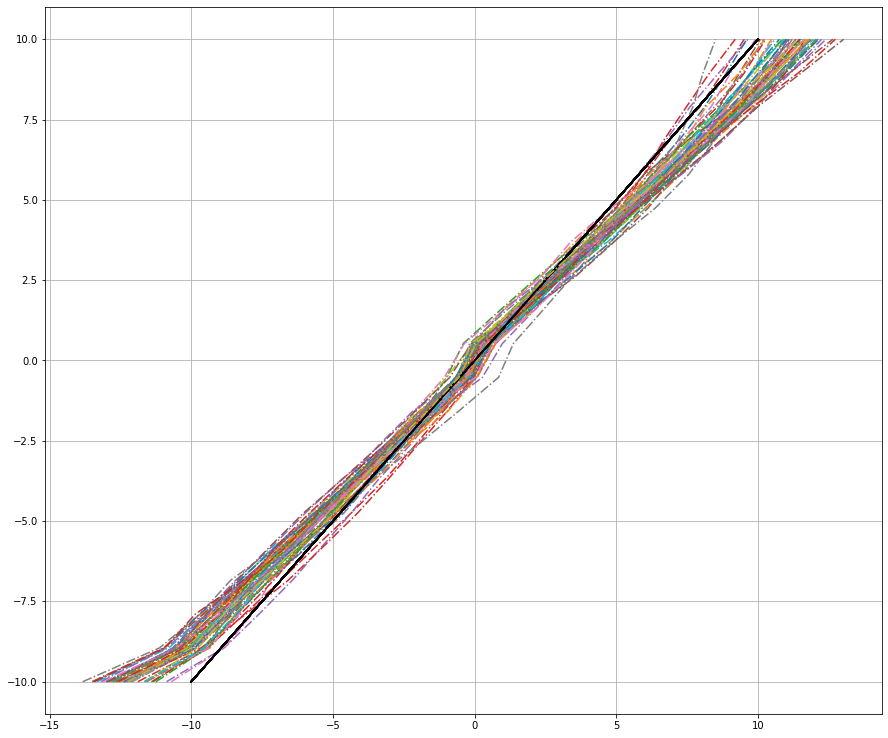

STD: 1.039


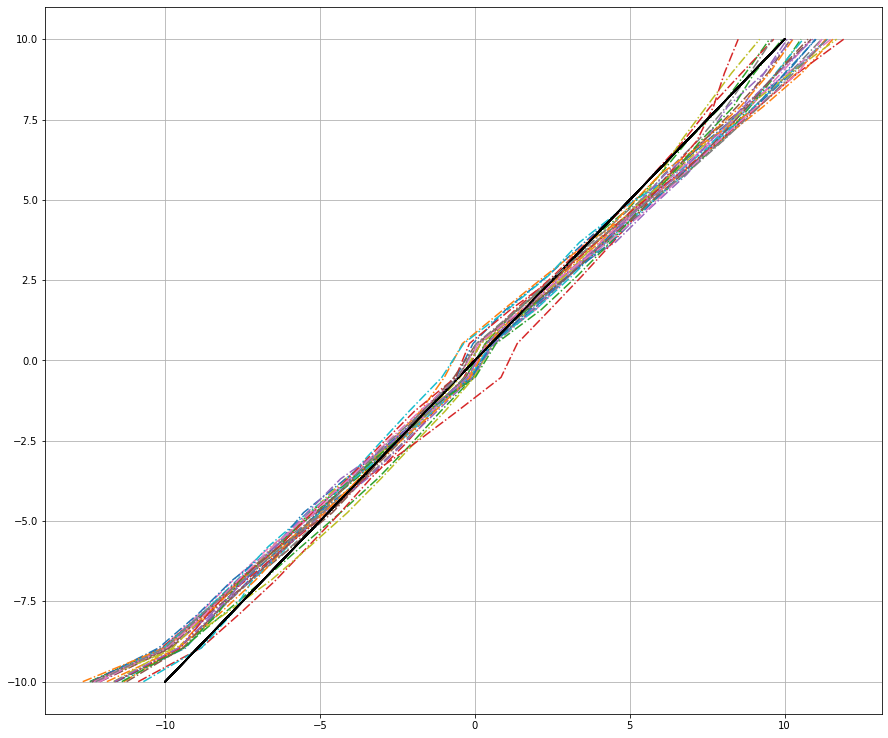

STD: 0.754
PARTIKEL ÖVER TID


In [11]:
cc = (cycler(color=list('bgrcmyk')))

def predict_on_stack(model, val_stack):
    """returns a numpy tensor containing propagated distance as well as the prediction, for ever propagation distance and every image images"""
    try:
        dets = np.array(model.predict_and_detect(val_stack, mode="ratio"))
    except ValueError as E:
        dets = np.expand_dims(np.zeros((val_stack.shape[0],3)), axis=0)
        print(E)
    dets = reshape_dets(dets)
    dets[:,2] *= multfact
    dets[:,2] -= np.mean(dets[:,2])
    return dets[:,2]

def reshape_dets(dets):
    """Removes all particles but the one closest to the center. If no particles are detected, sets the value to 0."""
    out = []
    for coords in dets:
        if coords.shape != (0, 3):
            x, y = IMAGE_SIZE//2, IMAGE_SIZE//2
            idx = np.argmin(np.array(coords[:,:2]- np.array((x, y))), axis=0)[0]
            out.append(coords[idx,:])
        else:
            out.append([0,0,0])
    return np.array(out)

def create_validation_stack(images, z_list):
    """"""
    output = []
    for i in range(images.shape[0]):
        image = images[i,:,:,:]
        stack = []
        for z in z_list:
            stack.append(propagate(image, z))
        output.append(stack)
    return np.stack((np.real(output), np.imag(output)), axis=-1)[:,:,:,:,0,:]

def plot_preds(val_stack):
    for particle_id in range(from_id, from_id+num_samples):
        dets = model.predict_and_detect(val_stack[:,:,:,:], mode="ratio"), 
        plt.figure(figsize=(10, 10))
        plt.imshow(np.abs(val_stack[stack_id,:,:,0]+1j*val_stack[stack_id,:,:,1]), cmap="bone")
        dets = np.squeeze(np.array(dets))
        print(dets)
        plt.scatter(dets[stack_id,1], dets[stack_id,0], s=200, facecolor="none", linewidths=3, edgecolors="g")
        plt.show()
        
        dets[:,2] *= multfact
        #dets[:,2] -= np.mean(dets[:,2])

        [print(d) for d in dets]

def evaluate_model(model, val_stack, prop_range):
    accs = []
    for i in range(num_samples):
        accs.append(predict_on_stack(model, val_stack[from_id+i]))
    accs = np.array(accs)

    stds = []
    fig, ax = plt.subplots(1,1, figsize=(15,13))
    for i in range(accs.shape[0]):
        ax.plot(prop_range, prop_range, 'k')
        ax.plot(accs[i,:].flatten(), prop_range, '-.')
        ax.grid(True)
        stds.append(np.std(accs[i,:].flatten() - prop_range))
    plt.show()
    print(f"STD: {np.std((accs-prop_range).flatten()):.3f}", )

    ids = np.where(stds < np.mean(stds))
    worst_ids = np.where(stds > 2*np.mean(stds))
    #print(f"worst: {worst_ids}")
    fig, ax = plt.subplots(1,1, figsize=(15,13))
    for i in range(accs[ids].shape[0]):
        ax.plot(prop_range, prop_range, 'k')
        ax.plot(accs[ids][i,:].flatten(), prop_range, '-.')
        ax.grid(True)
        stds.append(np.std(accs[ids][i,:].flatten() - prop_range))
    plt.show()
    print(f"STD: {np.std((accs[ids]-prop_range).flatten()):.3f}", )

model = models[-1]
prop_range = np.linspace(-10, 10, 20)
from_id = 0
num_samples = len(particles_positions[particle_id][:,0])-training_set_size
stack_id = len(prop_range)//2
multfact = -0.5
print(model.specs)
print("PROPAGERADE BILDER")
val_stack = create_validation_stack(validation_set, prop_range)
evaluate_model(model, val_stack, prop_range)

timeseries_images = np.stack( (np.real(validation_set[:,:,:,0]), np.imag(validation_set[:,:,:,0])), axis=-1)
z_corrections = predict_on_stack(model, timeseries_images) * multfact
z_corrections = z_corrections - np.mean(z_corrections)
#plot_preds(timeseries_images)
#show_id = 1

#fig, ax = plt.subplots(1,1, figsize=(15,13))
#plt.imshow(np.abs(val_stack[show_id,stack_id,:,:,0]+1j*val_stack[show_id,stack_id,:,:,1]), cmap="bone")
#plt.show()

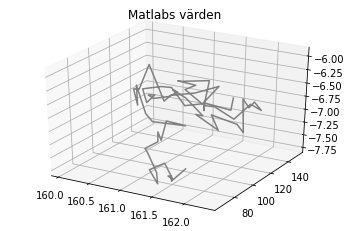

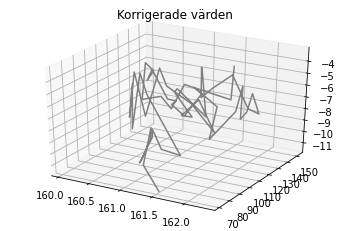

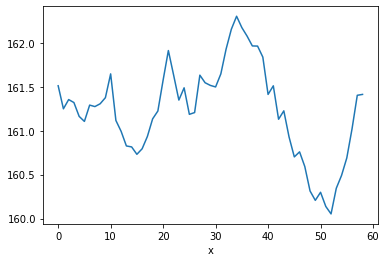

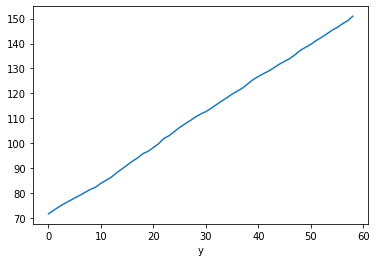

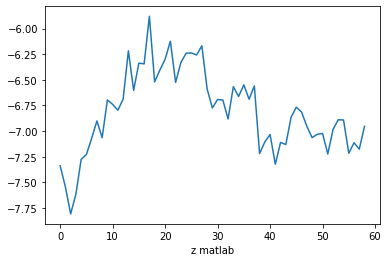

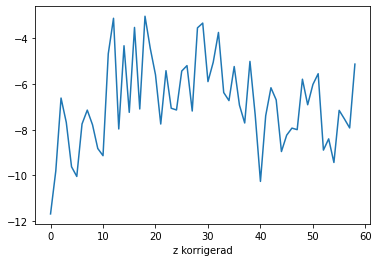

Sigma_z^2 matlab: 1.98
Sigma_z^2 korrigerad med nätverket: -110.63


In [15]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.plot3D(particles_positions[particle_id][:,0], particles_positions[particle_id][:,1], particles_positions[particle_id][:,2], 'gray')
ax.set_title("Matlabs värden")
plt.show()

ax = plt.axes(projection='3d')
ax.plot3D(particles_positions[particle_id][training_set_size:,0], particles_positions[particle_id][training_set_size:,1], particles_positions[particle_id][training_set_size:,2]+z_corrections, 'gray')
ax.set_title("Korrigerade värden")
plt.show()

plt.plot(list(range(len(particles_positions[particle_id][training_set_size:,0]))), particles_positions[particle_id][training_set_size:,0])
plt.xlabel("x")
plt.show()
plt.plot(list(range(len(particles_positions[particle_id][training_set_size:,0]))), particles_positions[particle_id][training_set_size:,1])
plt.xlabel("y")
plt.show()
plt.plot(list(range(len(particles_positions[particle_id][training_set_size:,0]))), particles_positions[particle_id][training_set_size:,2])
plt.xlabel("z matlab")
plt.show()
plt.plot(list(range(len(particles_positions[particle_id][training_set_size:,0]))), particles_positions[particle_id][training_set_size:,2]+z_corrections)
plt.xlabel("z korrigerad")
plt.show()

z_old = particles_positions[particle_id][training_set_size:,2]
z_new = particles_positions[particle_id][training_set_size:,2]+z_corrections

sigma_square_old = np.mean(
        np.dot(
            np.diff(np.append(z_old, [0])),
            np.diff(np.append([0], z_old))
))

sigma_square_new = np.mean(
        np.dot(
            np.diff(np.append(z_new, [0])),
            np.diff(np.append([0], z_new))
))

print(f"Sigma_z^2 matlab: {sigma_square_old:.2f}\nSigma_z^2 korrigerad med nätverket: {sigma_square_new:.2f}")
